# Quora Question Pairs

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Business Problem:

 Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.  

  Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
  
  
Problem Statement:
* Identify which questions asked on Quora are duplicates of questions that have already been asked.
* This could be useful to instantly provide answers to questions that have already been answered. 
* We are tasked with predicting whether a pair of questions are duplicates or not. 

# Business Objectives and constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# Data

* Size of Train.csv - 60MB
* Number of rows in Train.csv = 404,290
* Size of Train.csv - 60MBTrain.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
  - qid{1, 2}:  The unique ID of each question in the pair
  - question{1, 2}:  The actual textual contents of the questions.
  - is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

# Machine Learning Problem:

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

# Performance Metric:

* Confusion Matrix
* Log-Loss

# Load Data

In [2]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3

In [3]:
path = r'C:\Users\Friend\AI\AI_datasets\Quora'

In [4]:
data = pd.read_csv(os.path.join(path,"train.csv"))
print(data.shape)
data.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Exploratory Data Analysis without pre-processing:

In [5]:
#Basic Info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Questions that are not similar ; with class_label = 0 63.08
Questions that are similar ; with class_label = 1 36.92


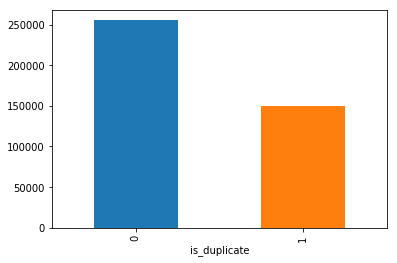

In [6]:
# Distribution of class labels:

print('Questions that are not similar ; with class_label = 0',(100 -round(data['is_duplicate'].mean()*100, 2)))
print('Questions that are similar ; with class_label = 1',round(data['is_duplicate'].mean()*100, 2))
data.groupby("is_duplicate")['id'].count().plot.bar()

unique questions from total pairs 537933
number of questions appeared more than once 111780
Max number of times a single question is repeated 157


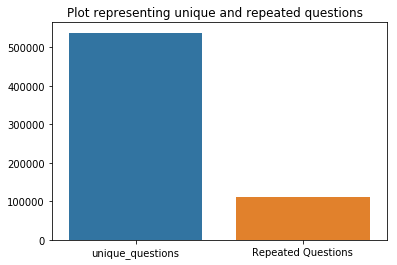

In [7]:
# Unique questions

qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('unique questions from total pairs', len(np.unique(qids)))
print('number of questions appeared more than once',np.sum(qids.value_counts() > 1))
print ('Max number of times a single question is repeated',max(qids.value_counts()))

#plot unique questions vs repeated questions
x = ["unique_questions" , "Repeated Questions"]
y =  [len(np.unique(qids)) , np.sum(qids.value_counts() > 1)]

plt.figure()
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [8]:
# Checking for duplicates

pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print('number of duplicates',data.shape[0]-pair_duplicates.shape[0])

number of duplicates 0


In [9]:
# Checking for null values

null_rows = data[data.isnull().any(1)]
print (null_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [10]:
# filling null values with empty strings

data = data.fillna('')
null_rows = data[data.isnull().any(1)]
print (null_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# Feature Extraction

In [11]:
if os.path.isfile(os.path.join(path,'data_fe_without_preprocessing_train.csv')):
    data = pd.read_csv(os.path.join(path,"data_fe_without_preprocessing_train.csv"),encoding='latin-1')
else:
    #  Frequency of qid1's
    data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
    # Frequency of qid2's
    data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
    # Length of q1
    data['q1len'] = data['question1'].str.len()
    # Length of q2
    data['q2len'] = data['question2'].str.len()
    # Number of words in Question 1
    data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
    # Number of words in Question 2
    data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

    # Number of common unique words in Question 1 and Question 2
    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    data['word_Common'] = data.apply(normalized_word_Common, axis=1)

    # Total num of words in Question 1 + Total num of words in Question 2
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    data['word_Total'] = data.apply(normalized_word_Total, axis=1)

    # (word_common)/(word_Total)
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    data['word_share'] = data.apply(normalized_word_share, axis=1)

    # sum total of frequency of qid1 and qid2
    data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
    # absolute difference of frequency of qid1 and qid2
    data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

    data.to_csv(os.path.join(path,"data_fe_without_preprocessing_train.csv"), index=False)

data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [12]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))
print ("Number of Questions with minimum length in question1 :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length in question2 :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length in question1 : 67
Number of Questions with minimum length in question2 : 24


C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


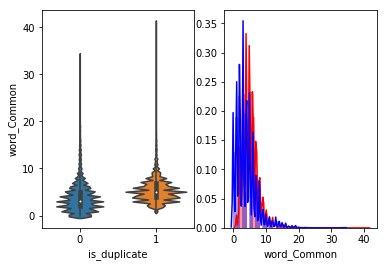

In [13]:
# word_Common
# The distributions of the word_Common feature in similar and non-similar questions are highly overlapping

plt.figure()
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = data[0:])
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


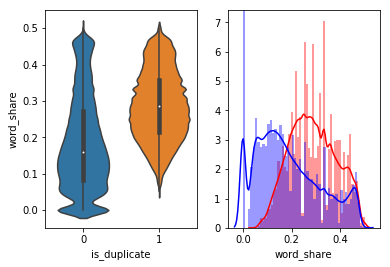

In [14]:
# word_share
# The distributions for word_share have some overlap on the far right-hand side,i.e., there are quite a lot of questions with high word similarity.The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

plt.figure()
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = data[0:])
plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

# Text Pre-processing

In [15]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup

In [16]:
data = pd.read_csv(os.path.join(path,"train.csv"))

# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()               
    
    return x

# Advanced Feature Extraction

In [17]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [18]:
def extract_features(df):
    
    # preprocessing each question
    
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)
    
    # Merging Features with dataset   
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    # Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    # Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    # Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    # Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    # Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    # Ratio of common_token_count to max lenghth of token count of Q1 and Q2
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    # Check if Last word of both questions is equal or not
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    # Check if First word of both questions is equal or not
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    # Abs. length difference
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    # Average Token Length of both Questions
    df["mean_len"]      = list(map(lambda x: x[9], token_features))    
    # Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    
    # Fuzzy features
        
    # measurement of edit distance-compare two strings
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    # measurement of edit distance-compare two strings partially
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    # tokenize both strings.split the tokens into two groups: intersection and remainder.
    # use those sets to build up a comparison string.
    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [7]:
if os.path.isfile(os.path.join(path,'nlp_features_train.csv')):
    data = pd.read_csv(os.path.join(path,"nlp_features_train.csv"),encoding='latin-1')
    data.fillna('')
else:
    data = pd.read_csv(os.path.join(path,"train.csv"))
    data = extract_features(data)
    data.to_csv(os.path.join(path,"nlp_features_train.csv"), index=False)
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


# Exploratory Data Analysis on Advanced Features

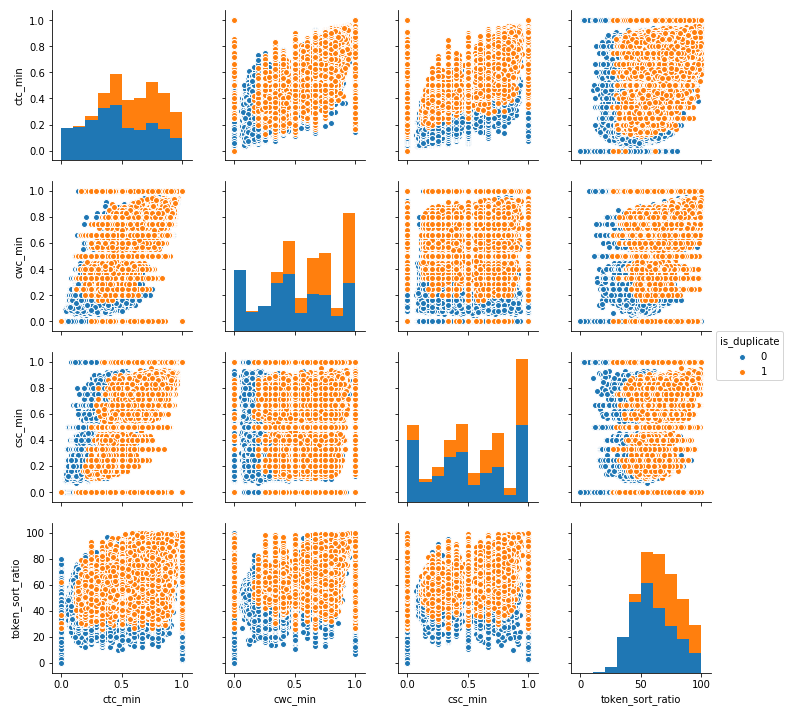

In [17]:
#EDA on advanced features
# From the plots given below it is very clear tat certain features gives us a clear cut value on deciding similarity.

n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


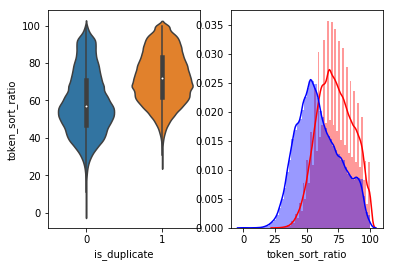

In [18]:
 # Distribution of the token_sort_ratio
    
plt.figure()

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Friend\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


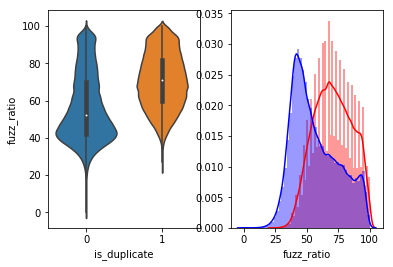

In [19]:
# Distribution of the fuzz_ratio

plt.figure()

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )

plt.show()

# Featurizations

In [22]:
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
data = pd.read_csv(os.path.join(path,"train.csv"))
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

# merge texts
question1 = list(data['question1'])
question1_train = question1[0:int(len(question1)*0.8)+1]
question1_test = question1[int(len(question1)*0.8)+1:len(question1)]

question2 = list(data['question2'])
question2_train = question1[0:int(len(question2)*0.8)+1]
question2_test = question1[int(len(question2)*0.8)+1:len(question2)]

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(lowercase=False,max_features = 100)
vocabulary = tf_idf_vect.fit(question1)
tf_idf_train = tf_idf_vect.transform(question1_train)
tf_idf_test = tf_idf_vect.transform(question1_test)

df3_train = pd.DataFrame(tf_idf_train.todense(), columns=tf_idf_vect.get_feature_names())
df3_test = pd.DataFrame(tf_idf_test.todense(), columns=tf_idf_vect.get_feature_names())

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(lowercase=False,max_features = 100)
vocabulary = tf_idf_vect.fit(question2_train)
tf_idf_train = tf_idf_vect.transform(question2_train)
tf_idf_test = tf_idf_vect.transform(question2_test)

df4_train = pd.DataFrame(tf_idf_train.todense(), columns=tf_idf_vect.get_feature_names())
df4_test = pd.DataFrame(tf_idf_test.todense(), columns=tf_idf_vect.get_feature_names())

# Data Preparation

In [26]:
#nlp_features_train.csv (NLP Features)

if os.path.isfile(os.path.join(path,'nlp_features_train.csv')):
    dfnlp = pd.read_csv(os.path.join(path,"nlp_features_train.csv"),encoding='latin-1')
    dfnlp = dfnlp.fillna('')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df1.shape

(404290, 17)

In [27]:
#prepro_features_train.csv (Simple Preprocessing Feartures)

if os.path.isfile(os.path.join(path,'data_fe_without_preprocessing_train.csv')):
    dfppro = pd.read_csv(os.path.join(path,"data_fe_without_preprocessing_train.csv"),encoding='latin-1')
    dfppro = dfppro.fillna('')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")
    
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2.shape

(404290, 12)

In [36]:
#Train Data
df12_train = df12.head(323433)

df3_train['id'] = [x for x in range(0,df12_train.shape[0])]
df4_train['id'] = [x for x in range(0,df12_train.shape[0])]

df34_train  = df3_train.merge(df4_train, on='id',how='left')
finaldata_train = df12_train.merge(df34_train, on='id',how='left')

y_train = finaldata_train['is_duplicate']
finaldata_train.drop(['id','is_duplicate'], axis=1, inplace=True)

X_train = finaldata_train[0:80000] 
y_train = y_train[0:80000]

print(X_train.shape,y_train.shape)

(80000, 226) (80000,)


In [37]:
#Test Data
df12_test = df12.tail(80857)

df3_test['id'] = [x for x in range(323433,323433+df12_test.shape[0])]
df4_test['id'] = [x for x in range(323433,323433+df12_test.shape[0])]

df34_test  = df3_test.merge(df4_test, on='id',how='left')
finaldata_test = df12_test.merge(df34_test, on='id',how='left')

y_test = finaldata_test['is_duplicate']
finaldata_test.drop(['id','is_duplicate'], axis=1, inplace=True)

X_test = finaldata_test[0:20000]
y_test = y_test[0:20000]

print(X_test.shape,y_test.shape)

(20000, 226) (20000,)


# Standardize data

In [46]:
from sklearn.preprocessing import StandardScaler

In [49]:
scaler = StandardScaler()
vocab = scaler.fit(X_train)
X_train = vocab.transform(X_train)
X_test = vocab.transform(X_test)

# Machine Learning Models

In [38]:
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import xgboost as xgb

C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Friend\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [51]:
from collections import Counter

train_distr = Counter(y_train)
train_len = len(y_train)
test_distr = Counter(y_test)
test_len = len(y_test)

In [52]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    B =(C/C.sum(axis=0))
    A =(((C.T)/(C.sum(axis=1))).T)
    plt.figure(figsize =(20,4))    
    labels = [1,2]
    
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [53]:
# Logistic Regression

from sklearn.linear_model import SGDClassifier

alpha = [10 ** x for x in range(-5, 2)]

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight = {0:.1, 1:.9})
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.47349575992134885
For values of alpha =  0.0001 The log loss is: 0.4388588184144344
For values of alpha =  0.001 The log loss is: 0.42396911815444327
For values of alpha =  0.01 The log loss is: 0.4525858652857807
For values of alpha =  0.1 The log loss is: 0.4935840951245068
For values of alpha =  1 The log loss is: 0.5178047797661722
For values of alpha =  10 The log loss is: 0.5269573682426553


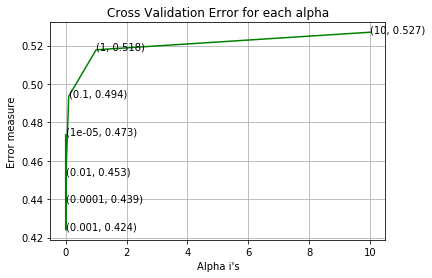

In [54]:
#plot errors

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [55]:
#Logistic regression for best alpha

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight = {0:.1, 1:.9})
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.001, average=False, class_weight={0: 0.1, 1: 0.9},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  0.001 The train log loss is: 0.4163257224039521
For values of best alpha =  0.001 The test log loss is: 0.42396911815444327
Total number of data points : 20000


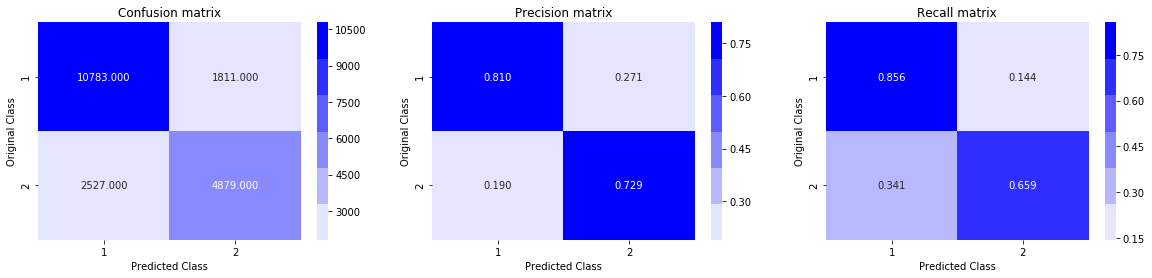

In [56]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [57]:
#Linear-SVM

log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight = {0:.1, 1:.9})
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.49451004474272786
For values of alpha =  0.0001 The log loss is: 0.5322143762461328
For values of alpha =  0.001 The log loss is: 0.5286363028921687
For values of alpha =  0.01 The log loss is: 0.5450504484161294
For values of alpha =  0.1 The log loss is: 0.6591257509095056
For values of alpha =  1 The log loss is: 0.6591257509095058
For values of alpha =  10 The log loss is: 0.6591257509095038


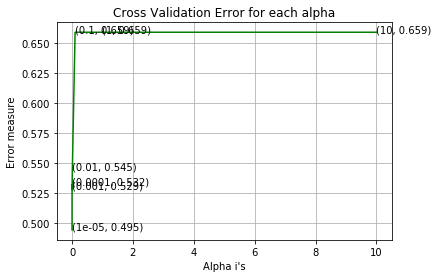

In [58]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [59]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight = {0:.1, 1:.9})
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=1e-05, average=False, class_weight={0: 0.1, 1: 0.9},
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
            cv=3, method='sigmoid')

For values of best alpha =  0.001 The train log loss is: 0.4163257224039521
For values of best alpha =  0.001 The test log loss is: 0.42396911815444327
Total number of data points : 20000


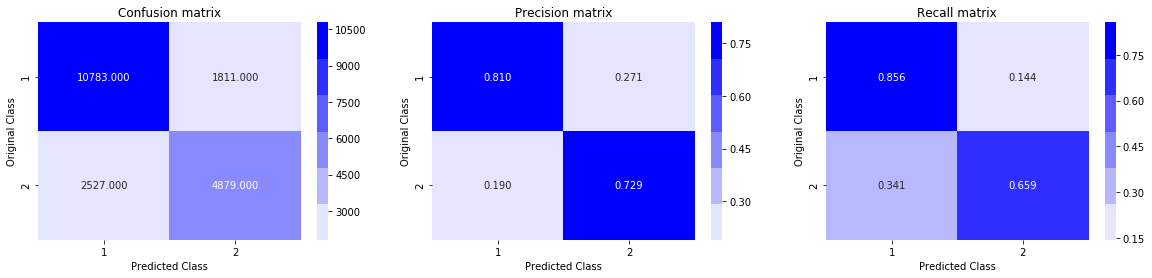

In [56]:
predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [62]:
max_depth = [4,8,10,50,100]
log_error_array = []

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02

for depth in max_depth:
    params['max_depth'] = depth
    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)    
    watchlist = [(d_train, 'train'), (d_test, 'valid')]    
    bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=10, verbose_eval=10)    
    xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = bst.predict(d_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[10:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	train-logloss:0.684834	valid-logloss:0.684929
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[10:33:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:33:51] src/

[10:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[70]	train-logloss:0.442357	valid-logloss:0.444351
[10:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:13] src/tree/updater_prune.cc:74: tree pruning

[10:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[140]	train-logloss:0.390811	valid-logloss:0.393781
[10:34:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:34:35] src/tree/updater_prune.cc:74: tree prunin

[10:34:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[210]	train-logloss:0.373287	valid-logloss:0.377302
[10:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:34:57] src/tree/updater_prune.cc:74: tree prunin

[10:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[10:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[280]	train-logloss:0.362834	valid-logloss:0.367563
[10:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[10:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:35:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:35:16] src/tree/updater_prune.cc:74: tree prunin

[10:35:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[350]	train-logloss:0.356239	valid-logloss:0.361804
[10:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:35:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[10:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[10:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[10:35:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[10:35:35] src/tree/updater_prune.cc:74: tree prunin

[10:35:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 418 extra nodes, 0 pruned nodes, max_depth=8
[10:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 404 extra nodes, 0 pruned nodes, max_depth=8
[10:35:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[10:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[20]	train-logloss:0.540977	valid-logloss:0.545857
[10:36:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[10:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 0 pruned nodes, max_depth=8
[10:36:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 414 extra nodes, 0 pruned nodes, max_depth=8
[10:36:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 428 extra nodes, 0 pruned nodes, max_depth=8
[10:36:03] src/tree/updater_prune.cc:74: tree

[10:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=8
[10:36:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 344 extra nodes, 0 pruned nodes, max_depth=8
[10:36:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=8
[10:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 0 pruned nodes, max_depth=8
[90]	train-logloss:0.373647	valid-logloss:0.389305
[10:36:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 304 extra nodes, 0 pruned nodes, max_depth=8
[10:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 294 extra nodes, 0 pruned nodes, max_depth=8
[10:36:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 318 extra nodes, 0 pruned nodes, max_depth=8
[10:36:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 0 pruned nodes, max_depth=8
[10:36:42] src/tree/updater_prune.cc:74: tree

[10:37:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=8
[10:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[10:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[10:37:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 pruned nodes, max_depth=8
[160]	train-logloss:0.33252	valid-logloss:0.356066
[10:37:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=8
[10:37:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=8
[10:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=8
[10:37:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 0 pruned nodes, max_depth=8
[10:37:23] src/tree/updater_prune.cc:74: tree

[10:38:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=8
[10:38:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 0 pruned nodes, max_depth=8
[10:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[10:38:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=8
[230]	train-logloss:0.317242	valid-logloss:0.345675
[10:38:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[10:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 194 extra nodes, 0 pruned nodes, max_depth=8
[10:38:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 0 pruned nodes, max_depth=8
[10:38:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 224 extra nodes, 0 pruned nodes, max_depth=8
[10:38:06] src/tree/updater_prune.cc:74: tre

[10:38:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[10:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 0 pruned nodes, max_depth=8
[10:38:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[10:38:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=8
[300]	train-logloss:0.308249	valid-logloss:0.341154
[10:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[10:38:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 0 pruned nodes, max_depth=8
[10:38:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 0 pruned nodes, max_depth=8
[10:38:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=8
[10:38:51] src/tree/updater_prune.cc:74: tre

[10:39:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=8
[10:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 0 pruned nodes, max_depth=8
[10:39:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=8
[10:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 156 extra nodes, 0 pruned nodes, max_depth=8
[370]	train-logloss:0.299539	valid-logloss:0.337773
[10:39:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=8
[10:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=8
[10:39:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 0 pruned nodes, max_depth=8
[10:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 0 pruned nodes, max_depth=8
[10:39:32] src/tree/updater_prune.cc:74: tre

[10:40:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 0 pruned nodes, max_depth=10
[10:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=10
[10:40:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 932 extra nodes, 0 pruned nodes, max_depth=10
[10:40:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 950 extra nodes, 0 pruned nodes, max_depth=10
[10:40:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 928 extra nodes, 0 pruned nodes, max_depth=10
[10:40:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned nodes, max_depth=10
[40]	train-logloss:0.447622	valid-logloss:0.46542
[10:40:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 988 extra nodes, 0 pruned nodes, max_depth=10
[10:40:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 0 pruned nodes, max_depth=10
[10:40:23] src/tree/updater_prune.cc:7

[10:41:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 674 extra nodes, 0 pruned nodes, max_depth=10
[10:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 642 extra nodes, 0 pruned nodes, max_depth=10
[10:41:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 614 extra nodes, 0 pruned nodes, max_depth=10
[10:41:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 638 extra nodes, 0 pruned nodes, max_depth=10
[10:41:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 618 extra nodes, 0 pruned nodes, max_depth=10
[10:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 622 extra nodes, 0 pruned nodes, max_depth=10
[10:41:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 620 extra nodes, 0 pruned nodes, max_depth=10
[110]	train-logloss:0.330741	valid-logloss:0.368134
[10:41:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[10:41:19] src/tree/updater_prune.cc

[10:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 410 extra nodes, 0 pruned nodes, max_depth=10
[10:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 0 pruned nodes, max_depth=10
[10:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 412 extra nodes, 0 pruned nodes, max_depth=10
[10:42:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 382 extra nodes, 0 pruned nodes, max_depth=10
[10:42:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 362 extra nodes, 0 pruned nodes, max_depth=10
[10:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 0 pruned nodes, max_depth=10
[10:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 392 extra nodes, 0 pruned nodes, max_depth=10
[10:42:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 342 extra nodes, 0 pruned nodes, max_depth=10
[180]	train-logloss:0.296573	valid-logloss:0.345879
[10:42:16] src/tree/updater_prune.cc

[10:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[10:43:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 0 pruned nodes, max_depth=10
[10:43:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 360 extra nodes, 0 pruned nodes, max_depth=10
[10:43:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[10:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 246 extra nodes, 0 pruned nodes, max_depth=10
[10:43:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 0 pruned nodes, max_depth=10
[10:43:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 0 pruned nodes, max_depth=10
[10:43:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 0 pruned nodes, max_depth=10
[10:43:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 0 p

[10:43:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 312 extra nodes, 0 pruned nodes, max_depth=10
[10:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 252 extra nodes, 0 pruned nodes, max_depth=10
[10:43:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 0 pruned nodes, max_depth=10
[10:44:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 340 extra nodes, 0 pruned nodes, max_depth=10
[10:44:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 0 pruned nodes, max_depth=10
[10:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 330 extra nodes, 0 pruned nodes, max_depth=10
[10:44:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 180 extra nodes, 0 pruned nodes, max_depth=10
[10:44:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 202 extra nodes, 0 pruned nodes, max_depth=10
[10:44:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 p

[10:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 0 pruned nodes, max_depth=10
[10:44:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 350 extra nodes, 0 pruned nodes, max_depth=10
[10:44:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 234 extra nodes, 0 pruned nodes, max_depth=10
[10:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 244 extra nodes, 0 pruned nodes, max_depth=10
[10:44:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 272 extra nodes, 0 pruned nodes, max_depth=10
[10:44:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 218 extra nodes, 0 pruned nodes, max_depth=10
[10:44:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 436 extra nodes, 0 pruned nodes, max_depth=10
[10:44:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 268 extra nodes, 0 pruned nodes, max_depth=10
[10:44:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 0 p

[10:48:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9174 extra nodes, 0 pruned nodes, max_depth=50
[10:48:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9192 extra nodes, 0 pruned nodes, max_depth=46
[10:48:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9104 extra nodes, 0 pruned nodes, max_depth=50
[50]	train-logloss:0.301931	valid-logloss:0.436443
[10:48:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9132 extra nodes, 0 pruned nodes, max_depth=49
[10:48:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9138 extra nodes, 0 pruned nodes, max_depth=50
[10:48:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9094 extra nodes, 0 pruned nodes, max_depth=50
[10:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9104 extra nodes, 0 pruned nodes, max_depth=47
[10:48:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9120 extra nodes, 0 pruned nodes, max_depth=45
[10:48:34] src/tree/updater_p

[10:52:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7298 extra nodes, 0 pruned nodes, max_depth=47
[10:52:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7280 extra nodes, 0 pruned nodes, max_depth=43
[10:52:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7144 extra nodes, 0 pruned nodes, max_depth=50
[10:52:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7198 extra nodes, 0 pruned nodes, max_depth=50
[120]	train-logloss:0.136455	valid-logloss:0.363799
[10:52:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7162 extra nodes, 0 pruned nodes, max_depth=48
[10:52:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7166 extra nodes, 0 pruned nodes, max_depth=50
[10:52:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7062 extra nodes, 0 pruned nodes, max_depth=50
[10:52:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7130 extra nodes, 0 pruned nodes, max_depth=49
[10:52:49] src/tree/updater_

[10:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5564 extra nodes, 0 pruned nodes, max_depth=50
[10:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5370 extra nodes, 0 pruned nodes, max_depth=50
[10:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5480 extra nodes, 0 pruned nodes, max_depth=49
[10:56:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5402 extra nodes, 0 pruned nodes, max_depth=49
[10:56:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5366 extra nodes, 0 pruned nodes, max_depth=49
[190]	train-logloss:0.078444	valid-logloss:0.3525
[10:56:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5372 extra nodes, 0 pruned nodes, max_depth=50
[10:57:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5330 extra nodes, 0 pruned nodes, max_depth=50
[10:57:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5344 extra nodes, 0 pruned nodes, max_depth=50
[10:57:08] src/tree/updater_pr

[21:48:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9254 extra nodes, 0 pruned nodes, max_depth=62
[21:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9196 extra nodes, 0 pruned nodes, max_depth=47
[21:48:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9290 extra nodes, 0 pruned nodes, max_depth=53
[40]	train-logloss:0.3473	valid-logloss:0.461656
[21:48:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9296 extra nodes, 0 pruned nodes, max_depth=53
[21:48:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9220 extra nodes, 0 pruned nodes, max_depth=47
[21:48:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9258 extra nodes, 0 pruned nodes, max_depth=57
[21:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9236 extra nodes, 0 pruned nodes, max_depth=54
[21:48:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9222 extra nodes, 0 pruned nodes, max_depth=49
[21:48:51] src/tree/updater_pru

[21:51:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7542 extra nodes, 0 pruned nodes, max_depth=51
[21:51:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7532 extra nodes, 0 pruned nodes, max_depth=63
[21:51:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7604 extra nodes, 0 pruned nodes, max_depth=50
[21:52:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7528 extra nodes, 0 pruned nodes, max_depth=47
[110]	train-logloss:0.150074	valid-logloss:0.36736
[21:52:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7474 extra nodes, 0 pruned nodes, max_depth=45
[21:52:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7486 extra nodes, 0 pruned nodes, max_depth=52
[21:52:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7384 extra nodes, 0 pruned nodes, max_depth=50
[21:52:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7424 extra nodes, 0 pruned nodes, max_depth=49
[21:52:21] src/tree/updater_p

[21:56:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5806 extra nodes, 0 pruned nodes, max_depth=71
[21:56:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5784 extra nodes, 0 pruned nodes, max_depth=56
[21:56:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5714 extra nodes, 0 pruned nodes, max_depth=64
[21:56:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5664 extra nodes, 0 pruned nodes, max_depth=49
[21:56:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5574 extra nodes, 0 pruned nodes, max_depth=58
[180]	train-logloss:0.083874	valid-logloss:0.352549
[21:56:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5578 extra nodes, 0 pruned nodes, max_depth=54
[21:56:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5624 extra nodes, 0 pruned nodes, max_depth=53
[21:56:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5648 extra nodes, 0 pruned nodes, max_depth=51
[21:56:49] src/tree/updater_

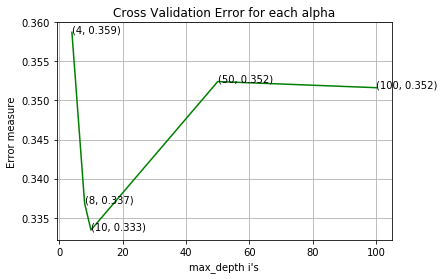

In [63]:
fig, ax = plt.subplots()
ax.plot(max_depth, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("max_depth i's")
plt.ylabel("Error measure")
plt.show()

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = max_depth[np.argmin(log_error_array)]

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y_train = bst.predict(d_train)
predict_y_test = bst.predict(d_test)

For values of best depth =  10 The train log loss is: 0.2620397457373918
For values of best depth =  10 The test log loss is: 0.3334446800083824


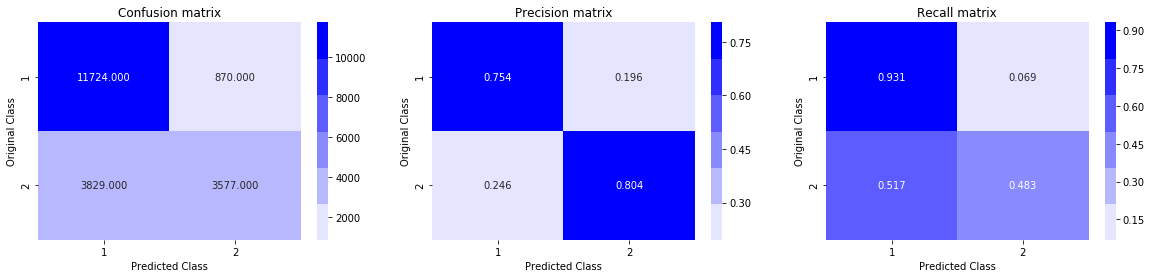

In [65]:
print('For values of best depth = ',max_depth[np.argmin(log_error_array)] , "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
print('For values of best depth = ',max_depth[np.argmin(log_error_array)] , "The test log loss is:",log_loss(y_test, predict_y_test, labels=clf.classes_, eps=1e-15))
plot_confusion_matrix(y_test, predicted_y)

# Summary:

1. Understand business problem
2. Jot down Business objectives and contraints
3. Data Information
4. Mapping to ML.
5. Decinding performance metrics
6. Load data
7. Exploratory Data Analysis without pre-processing
   * Basic data info
   * Distribution of class labels
   * Unique questions
   * Checking for duplicates
   * Checking for null values
   * filling null values with empty strings
8. Feature Extraction
   * freq_qid1 = Frequency of qid1's
   * freq_qid2= Frequency of qid2's 
   * q1len = Length of q1
   * q2len = Length of q2
   * q1_n_words = Number of words in Question 1
   * q2_n_words = Number of words in Question 2
   * word_Common = (Number of common unique words in Question 1 and Question 2)
   * word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
   * word_share = (word_common)/(word_Total)
   * freq_q1+freq_q2 = sum total of frequency of qid1 and qid2 
   * freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2 
9. Text Pre-processing
   * Removing html tags 
   * Removing Punctuations
   * Performing stemming
   * Removing Stopwords
   * Expanding contractions
10. Advanced Feature Extraction
    * cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
    * cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
    * csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
    * csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
    * ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
    * ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
    * last_word_eq : Check if First word of both questions is equal or not
    * first_word_eq : Check if First word of both questions is equal or not
    * abs_len_diff : Abs. length difference
    * mean_len : Average Token Length of both Questions
    * fuzz_ratio : measurement of edit distance-compare two strings
    * fuzz_partial_ratio : measurement of edit distance-compare two strings partially
    * token_set_ratio : tokenize both strings.split the tokens into two groups: intersection and remainder.use those sets to build up a comparison string.
    * token_sort_ratio : tokenizing the string in question, sorting the tokens alphabetically, and then joining them back into a string We then compare the transformed strings with a simple ratio().
11. Exploratory Data Analysis on Advanced Features.
    * pair plot on four features(ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio).From the plots given below it is very clear tat certain features gives us a clear cut value on deciding similarity.
    * Univariate Analysis on token_sort_ratio and fuzz_ratio
12. Featurization(tf-idf weighted word to vec)
    * tf-idf  vectorization question1
    * tf-idf vectorization question2
13. Data Preparation(Load final_features.csv - 226)
     * Load nlp_features_train.csv (NLP Features - 17)
     * Load prepro_features_train.csv (Simple Preprocessing Feartures - 12)
     * tf-idf vectorization question1(100)
     * tf-idf vectorization question2(100)
14. ML models
    * Logistic Regression
    * Linear SVM
    * XGBoost
15. Conclusion:

|Model|train log-loss|test log-loss|
|---|---|---|
|Logistic Regression|0.4342389101511353|0.4421663977505779|
|Linear SVM|0.46955106918493666|0.4800812551095535|
|XGBoost|0.2620397457373918|0.33344952850797854|